Running Trials: 100%|██████████| 5/5 [00:00<00:00, 19.89it/s]


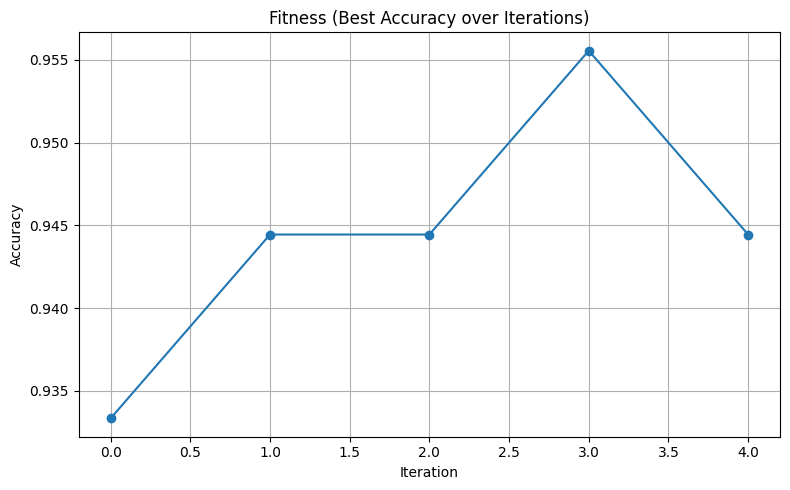

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import NuSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Load and sample the dataset for quicker testing
df = pd.read_excel("/content/Dry_Bean_Dataset.xlsx")
df = df.sample(300, random_state=42)  # Use only 300 samples to speed things up

# Step 2: Encode the target labels
le = LabelEncoder()
df['Class'] = le.fit_transform(df['Class'])

# Step 3: Features and target split
X = df.drop(columns=['Class'])
y = df['Class']

# Step 4: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Define a smaller parameter grid
param_grid = {
    'kernel': ['linear', 'rbf'],  # Faster, more stable kernels
    'nu': np.round(np.linspace(0.1, 0.3, 5), 3)  # Safe values
}

# Step 6: Initialize result containers
results = []
convergence_data = []
iterations = 5  # Reduced from 30 to 5

# Step 7: Run 5 test cycles
for i in tqdm(range(5), desc="Running Trials"):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=i)

    best_acc = 0
    best_params = {}
    acc_per_iter = []

    for _ in range(iterations):
        try:
            params = {
                'kernel': np.random.choice(param_grid['kernel']),
                'nu': np.random.choice(param_grid['nu']),
            }
            model = NuSVC(**params)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            acc_per_iter.append(acc)

            if acc > best_acc:
                best_acc = acc
                best_params = params
        except ValueError:
            acc_per_iter.append(0)  # Handle rare invalid nu

    results.append({
        'Sample': f'S{i+1}',
        'Best Accuracy': round(best_acc * 100, 2),
        'Best Parameters': f"{best_params.get('kernel', '-')}, {round(best_params.get('nu', 0), 2)}"
    })
    convergence_data.append(acc_per_iter)

# Step 8: Save results
results_df = pd.DataFrame(results)
results_df.to_excel("Optimized_SVM_Results.xlsx", index=False)

# Step 9: Plot convergence graph of best sample
best_index = np.argmax([r['Best Accuracy'] for r in results])
best_convergence = convergence_data[best_index]

plt.figure(figsize=(8, 5))
plt.plot(best_convergence, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Fitness (Best Accuracy over Iterations)")
plt.grid(True)
plt.tight_layout()
plt.savefig("convergence_plot.png")
plt.show()
